In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/proyectos3/
!ls

/content/drive/MyDrive/proyectos3
alexNet.ipynb  efficientNet.ipynb  fusion_plant     models    PlantVillage_bgremoved  wandb
cnn.ipynb      evaluation	   GoogleNet.ipynb  PlantDoc  resNet.ipynb


In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset


train_dir0 = './fusion_plant/train'

val_dir0 = './fusion_plant/valid'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir0, transform=transform,  is_valid_file=lambda x: x.endswith('.JPG') or x.endswith('.jpg'))
val_dataset = ImageFolder(val_dir0, transform=transform, is_valid_file=lambda x: x.endswith('.JPG') or x.endswith('.jpg'))

classes = train_dataset.classes
classes_val = val_dataset.classes
classes, classes_val

(['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'],
 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'])

In [ ]:
image_count = {}
for cls in classes:
  image_count[cls] = len(list(filter(lambda x: x[1] == classes.index(cls), train_dataset.samples)))

print(image_count)


{'Potato___Early_blight': 809, 'Potato___Late_blight': 813, 'Potato___healthy': 822}


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 8 # Número de procesos que se utilizarán para cargar datos en paralelo
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, f1_score

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        # nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def training_accuracy(self, batch):
        images, labels = batch
        out = self(images)
        preds = torch.argmax(out, dim=1)
        return accuracy(out, labels)

    def validation_step(self, batch):
        "calculate loss, accuracy, precision and f1 score for a batch of validation data"
        images, labels = batch
        out = self(images)                   # Generate prediction
        # nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss
        loss = F.cross_entropy(out, labels)  # Calculate loss
        preds = torch.argmax(out, dim=1)
        acc = accuracy(out, labels)          # Calculate accuracy

        # calculate precision and f1 score
        precision = precision_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average='macro')
        return {'val_loss': loss.detach(), 'val_accuracy': acc, 'val_precision': precision, 'val_f1': f1}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss.item(), "val_accuracy": epoch_accuracy.item()} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


In [ ]:
class EfficientNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b0', pretrained=True)
        self.network.classifier = nn.Linear(self.network.classifier.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
!ls

alexNet.ipynb  efficientNet.ipynb  fusion_plant     models    PlantVillage_bgremoved  wandb
cnn.ipynb      evaluation	   GoogleNet.ipynb  PlantDoc  resNet.ipynb


In [ ]:
model = EfficientNet(len(classes))
model = to_device(model, device)
# model.load_state_dict(torch.load('./models/plant_disease_aug_efficientNet_100.pth', map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [ ]:
from torchsummary import summary              # for getting the summary of our model

# getting summary of the model
INPUT_SHAPE = (3, 224, 224)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
            Conv2d-7              [-1, 8, 1, 1]             264
              SiLU-8              [-1, 8, 1, 1]               0
            Conv2d-9             [-1, 32, 1, 1]             288
    SqueezeExcite-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 16, 112, 112]             512
      BatchNorm2d-12         [-1, 16, 112, 112]              32
         Identity-13         [-1, 16, 112, 112]               0
DepthwiseSeparableConv-14         [-1, 

In [ ]:
epochs = 100

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
!pip install wandb

In [ ]:
import wandb

name = f'efficientNet-{epochs}-epochs'
wandb.init(project="plantvillage-aug-final", name=name, config={
    "epochs": epochs,
    "learning_rate": max_lr,
    "grad_clip": grad_clip,
    "weight_decay": weight_decay,
    "opt_func": opt_func.__name__,
    "batch_size": batch_size,
    "dataset": "PlantVillage",
    "architecture": "EfficientNet"
})


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▅▇█▇▅▂▆▄▇▇▅▁▅▆▄▇▇▅▇▆▇▇▆▇▇█▅█▇██▇▇█▇▇██▇█
Train Loss,▃▁▁▁▂█▃▃▂▂▂▄▂▂▃▂▁▂▁▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁
Val Accuracy,█▆▄▁██████
Val F1,▇▄▃▁▇█████
Val Loss,▁▄▅█▁▁▁▁▁▁
Val Precision,█▅▂▁▇█████
Epoch,9
Train Accuracy,0.91667
Train Loss,0.10232
Val Accuracy,0.99792


In [ ]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    # return model.validation_epoch_end(outputs)
    val_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(val_losses).mean()       # Combine loss
    val_accuracies = [x["val_accuracy"] for x in outputs]
    epoch_accuracy = torch.stack(val_accuracies).mean()
    val_precisions = [x["val_precision"] for x in outputs]
    epoch_precision = torch.tensor(sum(val_precisions)/len(val_precisions))
    val_f1s = [x["val_f1"] for x in outputs]
    epoch_f1 = torch.tensor(sum(val_f1s)/len(val_f1s))
    return {"val_loss": epoch_loss.item(), "val_accuracy": epoch_accuracy.item(), "val_precision": epoch_precision.item(), "val_f1": epoch_f1.item()} # Combine accuracies


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            accuracy_train = model.training_accuracy(batch)

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()

            # logging to wandb
            wandb.log({"Train Loss": loss.item()})
            wandb.log({"Train Accuracy": accuracy_train.item()})

        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        # logging to wandb
        wandb.log({
            "Epoch": epoch,
            "Val Loss": result['val_loss'],
            "Val Accuracy": result['val_accuracy'],
            "Val Precision": result['val_precision'],
            "Val F1": result['val_f1']
        })

    return history

In [ ]:
%%time
history = fit_one_cycle(
  epochs,
  max_lr,
  model,
  train_loader,
  val_loader,
  grad_clip=grad_clip,
  weight_decay=1e-4,
  opt_func=opt_func
)

Epoch [0], last_lr: 0.00043, train_loss: 0.2062, val_loss: 0.0126, val_acc: 0.9917
Epoch [1], last_lr: 0.00050, train_loss: 0.0754, val_loss: 0.0599, val_acc: 0.9729
Epoch [2], last_lr: 0.00063, train_loss: 0.0632, val_loss: 0.0014, val_acc: 1.0000
Epoch [3], last_lr: 0.00081, train_loss: 0.0562, val_loss: 0.0157, val_acc: 0.9937
Epoch [4], last_lr: 0.00104, train_loss: 0.1282, val_loss: 0.0443, val_acc: 0.9896
Epoch [5], last_lr: 0.00131, train_loss: 0.0868, val_loss: 0.0126, val_acc: 0.9937
Epoch [6], last_lr: 0.00163, train_loss: 0.0708, val_loss: 0.0129, val_acc: 0.9958
Epoch [7], last_lr: 0.00198, train_loss: 0.0850, val_loss: 0.0346, val_acc: 0.9833
Epoch [8], last_lr: 0.00237, train_loss: 0.1016, val_loss: 0.0394, val_acc: 0.9937
Epoch [9], last_lr: 0.00280, train_loss: 0.1192, val_loss: 0.2645, val_acc: 0.9479
Epoch [10], last_lr: 0.00324, train_loss: 0.1070, val_loss: 0.0310, val_acc: 0.9958
Epoch [11], last_lr: 0.00371, train_loss: 0.1056, val_loss: 0.0231, val_acc: 0.9937
Ep

In [ ]:
torch.save(model.state_dict(), f'models/plant_disease_aug_efficientNet1_{epochs}.pth')

In [ ]:
data_test_dir = './PlantDoc/test'

In [ ]:
from torchvision import transforms


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torchvision.datasets import ImageFolder

dataset_test = ImageFolder(data_test_dir, test_transform)

In [ ]:
classes_test = dataset_test.classes
print(classes_test)
# ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
from torch.utils.data import DataLoader

data_loader_test = DataLoader(dataset_test)

In [ ]:
device = get_default_device()
model = EfficientNet(len(classes))
model = to_device(model, device)
model.load_state_dict(torch.load('./models/plant_disease_aug_efficientNet1_100.pth'))

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


<All keys matched successfully>

In [ ]:
test_loader = DeviceDataLoader(data_loader_test, device)

In [ ]:
# get accuracy
evaluate(model, test_loader)

{'val_loss': 1.5635696649551392,
 'val_accuracy': 0.7532467246055603,
 'val_precision': 1.0,
 'val_f1': 0.7532467532467533}

<Axes: >

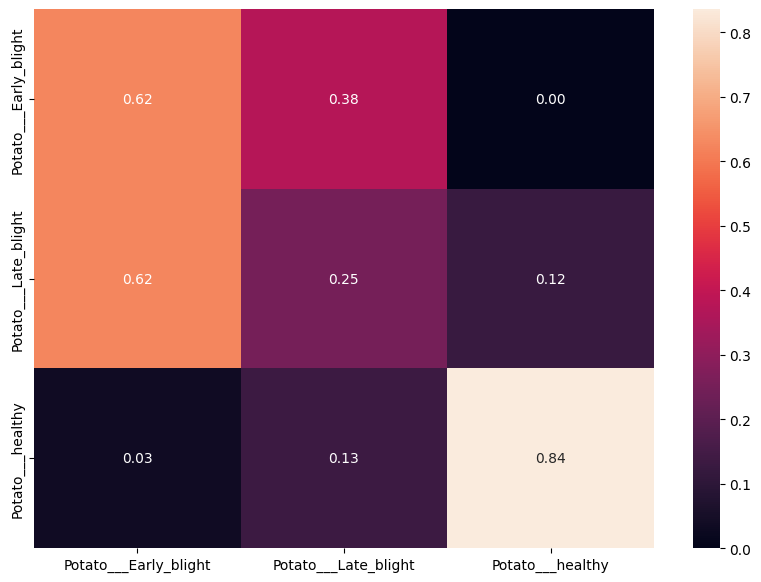

In [ ]:
# calcaulate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_predictions(model, loader):
    all_preds = []
    all_targets = []
    for batch in loader:
        images, targets = batch

        preds = model(images)
        all_preds.extend(preds.argmax(dim=-1).cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    return all_preds, all_targets


all_preds, all_targets = get_predictions(model, test_loader)

class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

cm = confusion_matrix(all_targets, all_preds, normalize='true')

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f')



<Axes: >

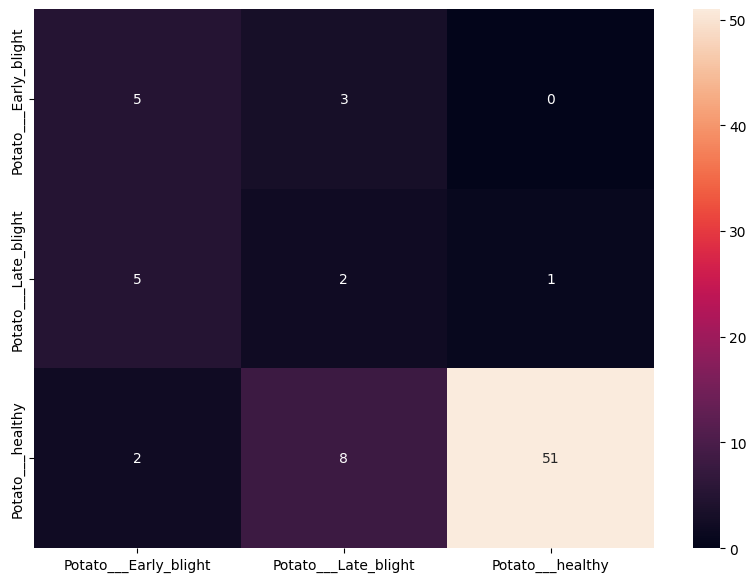

In [ ]:
# cm = confusion_matrix(all_targets, all_preds)

# plt.figure(figsize=(10, 10))
# sns.heatmap(cm, annot=True, fmt=".0f")
# plt.show()

cm = confusion_matrix(all_targets, all_preds)

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f')